In [2]:
import numpy as np
import scipy.optimize
from py_vlasov.util import zp, kzkp, list_to_complex, real_imag
from py_vlasov.wrapper import oblique_wrapper, disp_det, input_gen
from py_vlasov.transport_ratios import transport_ratios
from py_vlasov.follow_parameter import follow_k
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['xtick.minor.size'] = 3.5
mpl.rcParams['ytick.minor.size'] = 3.5
mpl.rcParams['xtick.major.width'] = 1.1
mpl.rcParams['ytick.major.width'] = 1.1
mpl.rcParams['xtick.minor.width'] = .8
mpl.rcParams['ytick.minor.width'] = .8
mpl.rcParams['legend.fontsize'] = 14
#xtick.major.size     : 3.5      # major tick size in points
#xtick.minor.size     : 2      # minor tick size in points
#xtick.major.width    : 0.8    # major tick width in points
#xtick.minor.width    : 0.6    # minor tick width in points

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
def fast_freq_fn(k, theta, betap):
    kz, kp = kzkp(k, theta)
    cos_theta = kz / k
    kdi = k / np.sqrt(betap)
    return kdi * np.sqrt(1 + kdi**2 * cos_theta**2)

def ea_freq_fn(k, theta, aol, the_tp, nc_nh):
    kz, kp = kzkp(k, theta)
    mp_me = 1836
    num = kz * np.sqrt(0.5 * nc_nh/(1+nc_nh) * the_tp * mp_me)
    k_rhose_2 = kp**2 * 0.5 * nc_nh/(1+nc_nh) * the_tp / mp_me
    kp_debye_2 = (kz**2+kp**2) * 0.5 * aol**2 * the_tp
    denom = np.sqrt(1 + k_rhose_2 + kp_debye_2)
    print(denom)
    return num / denom


    
def kdi_2_krhoi(kdi, betap):
    return kdi * np.sqrt(betap)

Given that $$v_{Te, h} = 0.6 c \omega_{ce} \cos\theta / \omega_{pe}$$
$$V_{Te, h} = \sqrt{\frac{k_BT_{e, h}}{m_e}}$$
Then
$$\beta_p = \frac{T_p}{T_e} 0.72 \cos{\theta}^2$$

In [6]:
theta = 5.
wpe_wce = 4
# wpe_wce = 1
the_tp = 60
# the_tp = 1
# the_tp = 1
fac = 0.6
# fac = 1e-2

# ===============

aol = 1/np.sqrt(1836)/wpe_wce
betap = 1/the_tp * np.cos(np.deg2rad(theta))**2 * 2* fac**2
print(betap)
# betap = 1e-4

print('aol = {0:.4g}'.format(aol))
print('beta_p = {0:.4g}'.format(betap))
print('beta_e = {0:.4g}'.format(betap * the_tp))

0.011908846518073248
aol = 0.005835
beta_p = 0.01191
beta_e = 0.7145


In [3]:
np.sqrt(0.0153 * 60 / 2)

0.6774953874381728

In [87]:
tc_th = 1e-3
# tc_th = 1
nh_n0 = 0.65

t_list=[1., the_tp, the_tp * tc_th]
a_list=[1., 2, 1.]
n_list=[1., nh_n0, 1-nh_n0] 
q_list=[1.,-1., -1.]
m_list=[1., 1./1836., 1./1836]
v_list=[0.,0.,0.]
n = 15
method = 'pade'

kdi = 2

target_kde = 3.
target_kdi = target_kde * np.sqrt(1836)

k = kdi_2_krhoi(kdi, betap)
kz, kp = kzkp(k, theta)
print(k, kz, kp)

param = [kz, kp, betap, t_list, a_list, n_list, q_list,
         m_list, v_list, n, method, aol]

0.21825532312475907 0.21742479572718573 0.019022204795568508


In [88]:
target_k = kdi_2_krhoi(target_kdi, betap)
print('target_k = {0:.2f}'.format(target_k))
print('target_kde = {0:.3g}'.format(target_kdi / np.sqrt(1836.)))

# ELECTRON ACOUSTIC MODE

# seed_freq = fast_freq(k, theta, betap)
ea_seed_freq = ea_freq_fn(k, theta, aol, the_tp, nc_nh=n_list[2]/n_list[1])
f = lambda wrel:\
    real_imag(disp_det(list_to_complex(wrel), kz, kp, betap,
                              t_list, a_list, n_list, q_list, \
                              m_list, v_list, method = 'numpy', n = 6, \
                              aol=aol))
ea_guess = ea_seed_freq * (1-.5j) #* .6
# guess = wr + 1j * wi
# guess = 123 - 115j
print('ea_seed_freq = {0:.3g}'.format(ea_guess))

wr, wi = scipy.optimize.fsolve(f, real_imag(ea_guess))

print('wr = {0:.3g}'.format(wr))
print('wi = {0:.3g}'.format(wi))
print(wr/1836/np.cos(np.deg2rad(theta)))
ea_freq = follow_k(ea_guess, target_k, param,
                log_incrmt = 0.02, incrmt_method = 'log')

target_k = 14.03
target_kde = 3
1.000025357988338
ea_seed_freq = 30.2-15.1j
wr = 30.5
wi = -13
0.01667852730484382


In [89]:
# WHISTLER MODE

whistler_seed_freq = fast_freq_fn(k, theta, betap)
f = lambda wrel:\
    real_imag(disp_det(list_to_complex(wrel), kz, kp, betap,
                              t_list, a_list, n_list, q_list, \
                              m_list, v_list, method = 'numpy', n = 6, \
                              aol=aol))
whistler_guess = whistler_seed_freq 
print('whistler_seed_freq = {0:.3g}'.format(whistler_guess))

wr, wi = scipy.optimize.fsolve(f, real_imag(whistler_guess))

print('wr = {0:.3g}'.format(wr))
print('wi = {0:.3g}'.format(wi))
print(wr/1836/np.cos(np.deg2rad(theta)))
whistler_freq = follow_k(whistler_guess, target_k, param,
                log_incrmt = 0.02, incrmt_method = 'log')

whistler_seed_freq = 4.46
wr = 5.73
wi = -0.00403
0.003133262430135219


In [90]:
kde_start = kdi / np.sqrt(1836)
kde_end = np.sqrt(ea_freq[1][0]**2 + ea_freq[1][1]**2) /np.sqrt(1836) / np.sqrt(betap)
ea_freq_arr = np.array(ea_freq[-1])
kde_list = np.logspace(np.log10(kde_start), np.log10(kde_end), len(ea_freq_arr))

whistler_freq_arr = np.array(whistler_freq[-1])

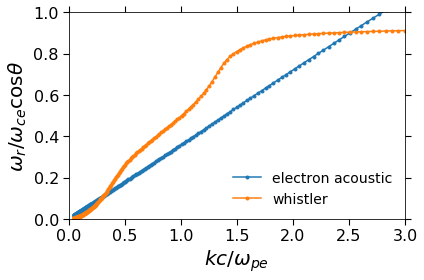

In [91]:
plt.plot(kde_list, ea_freq_arr.real/1836/np.cos(np.deg2rad(theta)), '.-', label = 'electron acoustic')
plt.plot(kde_list, whistler_freq_arr.real/1836/np.cos(np.deg2rad(theta)), '.-', label = 'whistler')
# plt.plot(kde_whistler, freq_whistler.real)
plt.xlabel('$kc/\omega_{pe}$')
plt.ylabel(r'$\omega_r/\omega_{ce} \cos \theta $')
plt.ylim([0, 1.])
plt.xlim([0, 3])
plt.legend(frameon=False)
plt.tight_layout()
# plt.savefig('whistler_ea_dispersion_real_1.png')

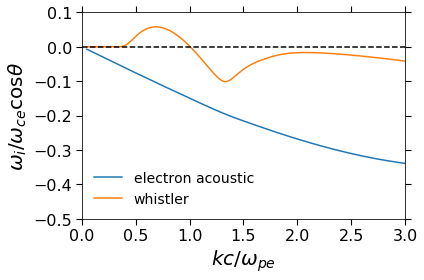

In [92]:
plt.plot(kde_list, ea_freq_arr.imag/1836/np.cos(np.deg2rad(theta)), label = 'electron acoustic')
plt.plot(kde_list, whistler_freq_arr.imag/1836/np.cos(np.deg2rad(theta)), label = 'whistler')
plt.xlabel('$kc/\omega_{pe}$')
plt.ylabel(r'$\omega_i/\omega_{ce} \cos \theta $')
plt.ylim([-.5, .1])
plt.xlim([0, 3])
plt.legend(frameon=False)
plt.axhline(0, color = 'k', linestyle = 'dashed')
plt.tight_layout()
# plt.savefig('whistler_ea_dispersion_imag_1.png')

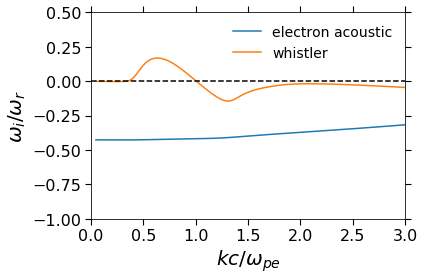

In [93]:
plt.plot(kde_list, ea_freq_arr.imag/ea_freq_arr.real, label = 'electron acoustic')
plt.plot(kde_list, whistler_freq_arr.imag/whistler_freq_arr.real, label = 'whistler')
plt.xlabel('$kc/\omega_{pe}$')
plt.ylabel(r'$\omega_i/\omega_r$')
plt.ylim([-1, .5])
plt.xlim([0, 3])
plt.legend(frameon=False)
plt.axhline(0, color = 'k', linestyle = 'dashed')
plt.tight_layout()
# plt.savefig('whistler_ea_dispersion_imag_2.png')

In [36]:
# TRANSPORT RATIOS

In [37]:
def get_transport_ratios(k_list, freq_arr):
    ex_ez_list = []
    ey_ez_list = []
    by_bx_list = []
    
    eigen_e_list = []
    eigen_b_list = []
    dt_list = []

    for i in range(len(k_list)):
        freq_i = freq_arr[i]
        kz, kp = kzkp(k_list[i], theta)
#         inp = input_gen(freq_i, kp, kz, betap)
        inp = input_gen(freq_i, kz, kp, betap, t_list, \
              a_list, n_list, q_list, m_list, v_list, \
              n, method = method, aol=aol)
    
        tr = transport_ratios(inp, print_result = False)
        eigen_e = tr['eigen_e']
        kvec = np.array([kp, 0, kz])
        khat = kvec/np.linalg.norm(kvec)
        ez_prime = np.dot(eigen_e, khat) * khat
        ey_prime = np.array([0, eigen_e[1], 0])
        ex_prime = eigen_e - ez_prime - ey_prime
        ex_ez = np.linalg.norm(ex_prime) / np.linalg.norm(ez_prime)
        ey_ez = np.linalg.norm(ey_prime) / np.linalg.norm(ez_prime)
        ex_ez_list.append(ex_ez)
        ey_ez_list.append(ey_ez)
        
        eigen_e_list.append(eigen_e)

        eigen_b = np.cross(kvec, eigen_e)
        bz_prime = np.dot(eigen_b, khat) * khat
        by_prime = np.array([0, eigen_b[1], 0])
        bx_prime = eigen_b - bz_prime - by_prime
        by_bx = np.linalg.norm(bx_prime) / np.linalg.norm(by_prime)
        by_bx_list.append(by_bx)
        
        eigen_b_list.append(eigen_b)
    return {'exez': ex_ez_list, 'eyez': ey_ez_list, 'bybx': by_bx_list, 'eigen_e':eigen_e_list, 'eigen_b':eigen_b_list}

In [38]:
k_end = np.sqrt(ea_freq[1][0]**2 + ea_freq[1][1]**2)
k_start = kdi_2_krhoi(kdi, betap)
k_list = np.logspace(np.log10(k_start), np.log10(k_end), len(ea_freq_arr))

In [39]:
ea_tr = get_transport_ratios(k_list, ea_freq_arr)

In [40]:
whistler_tr = get_transport_ratios(k_list, whistler_freq_arr.real)

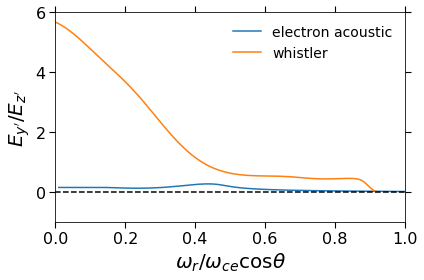

In [107]:
plt.plot(ea_freq_arr.real/1836/np.cos(np.deg2rad(theta)), ea_tr['exez'], label='electron acoustic')
plt.plot(whistler_freq_arr.real/1836/np.cos(np.deg2rad(theta)), whistler_tr['exez'], label = 'whistler')
plt.xlabel(r'$\omega_r/\omega_{ce} \cos \theta $')
plt.ylabel('$E_{y^\prime}/E_{z^\prime}$')
plt.axhline(0, linestyle='dashed', color='k')
plt.ylim([-1, 6])
plt.xlim([0, 1])
plt.legend(frameon=False)
plt.tight_layout()
# plt.savefig('whistler_ea_eyez_1.png')

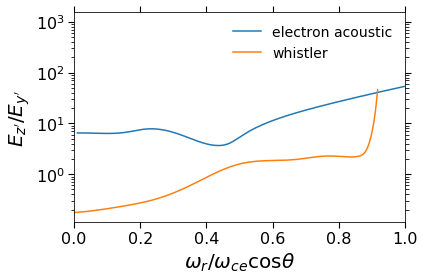

In [104]:
plt.plot(ea_freq_arr.real/1836/np.cos(np.deg2rad(theta)), 1/np.array(ea_tr['exez']), label='electron acoustic')
plt.plot(whistler_freq_arr.real/1836/np.cos(np.deg2rad(theta)), 1/np.array(whistler_tr['exez']), label = 'whistler')
plt.xlabel(r'$\omega_r/\omega_{ce} \cos \theta $')
plt.ylabel('$E_{z^\prime}/E_{y^\prime}$')
plt.axhline(0, linestyle='dashed', color='k')
# plt.ylim([-1, 6])
# plt.ylim([-.2, .2])
plt.xlim([0, 1])
plt.yscale('log')
plt.legend(frameon=False)
plt.tight_layout()
# plt.savefig('whistler_ea_ezey_1.png')

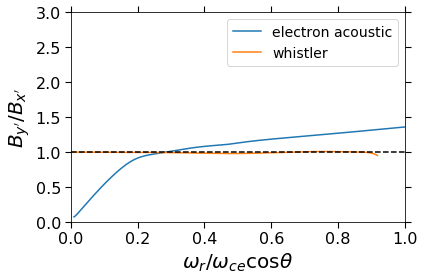

In [103]:
plt.plot(ea_freq_arr.real/1836/np.cos(np.deg2rad(theta)), ea_tr['bybx'], label='electron acoustic')
plt.plot(whistler_freq_arr.real/1836/np.cos(np.deg2rad(theta)), whistler_tr['bybx'], label='whistler')
plt.xlabel(r'$\omega_r/\omega_{ce} \cos \theta $')
plt.ylabel('$B_{y^\prime}/B_{x^\prime}$')
plt.axhline(1, linestyle='dashed', color='k')
plt.ylim([0, 3])
plt.xlim([0, 1])
plt.legend()
plt.tight_layout()
# plt.savefig('whistler_ea_bybx_1.png')

In [50]:
!ls *.png

whistler_ea_bybx_1.png            whistler_ea_dispersion_real_1.png
whistler_ea_dispersion_imag_1.png whistler_ea_eyez_1.png
whistler_ea_dispersion_imag_2.png


In [83]:
def eigen_xy(vec_arr):
    return np.array(list(map(lambda x: abs(x[0]/x[1]), vec_arr))), \
        np.array(list(map(lambda x: np.rad2deg(np.angle(x[0]/x[1])), vec_arr)))

In [84]:
ea_eigen_e_xy = eigen_xy(ea_tr['eigen_e'])
ea_eigen_b_xy = eigen_xy(ea_tr['eigen_b'])
whistler_eigen_e_xy = eigen_xy(whistler_tr['eigen_e'])
whistler_eigen_b_xy = eigen_xy(whistler_tr['eigen_b'])

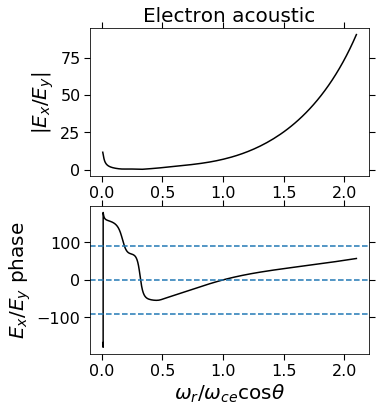

In [97]:
fig, axes = plt.subplots(2, 1, figsize = [5, 6])
ax0, ax1 = axes
ax0.set_title('Electron acoustic')
ax0.plot(ea_freq_arr.real/1836/np.cos(np.deg2rad(theta)), ea_eigen_e_xy[0], 'k')
ax0.set_ylabel(r'$|E_{x}/E_{y}|$')
ax1.plot(ea_freq_arr.real/1836/np.cos(np.deg2rad(theta)), ea_eigen_e_xy[1], 'k')
ax1.set_xlabel(r'$\omega_r/\omega_{ce} \cos \theta $')
ax1.set_ylabel(r'$E_{x}/E_{y}$ phase')
ax1.axhline(0, linestyle = 'dashed')
ax1.axhline(-90, linestyle = 'dashed')
ax1.axhline(90, linestyle = 'dashed')

(-180, 180)

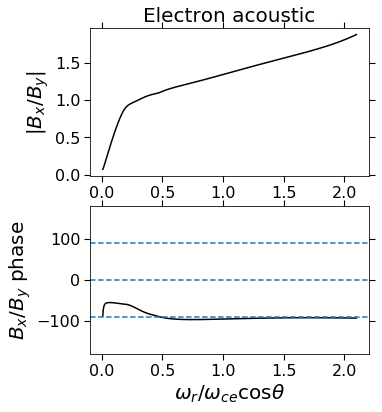

In [98]:
fig, axes = plt.subplots(2, 1, figsize = [5, 6])
ax0, ax1 = axes
ax0.set_title('Electron acoustic')
ax0.plot(ea_freq_arr.real/1836/np.cos(np.deg2rad(theta)), ea_eigen_b_xy[0], 'k')
ax0.set_ylabel(r'$|B_{x}/B_{y}|$')
ax1.plot(ea_freq_arr.real/1836/np.cos(np.deg2rad(theta)), ea_eigen_b_xy[1], 'k')
ax1.set_xlabel(r'$\omega_r/\omega_{ce} \cos \theta $')
ax1.set_ylabel(r'$B_{x}/B_{y}$ phase')
ax1.axhline(0, linestyle = 'dashed')
ax1.axhline(-90, linestyle = 'dashed')
ax1.axhline(90, linestyle = 'dashed')
ax1.set_ylim([-180, 180])


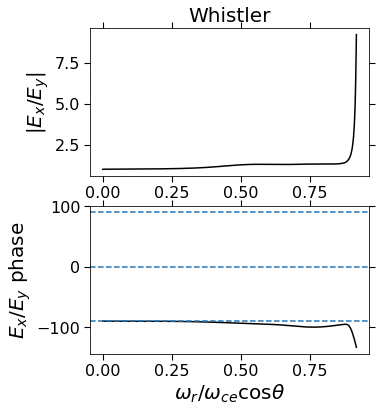

In [99]:
fig, axes = plt.subplots(2, 1, figsize = [5, 6])
ax0, ax1 = axes
ax0.set_title('Whistler')
ax0.plot(whistler_freq_arr.real/1836/np.cos(np.deg2rad(theta)), whistler_eigen_e_xy[0], 'k')
ax0.set_ylabel(r'$|E_{x}/E_{y}|$')
ax1.plot(whistler_freq_arr.real/1836/np.cos(np.deg2rad(theta)), whistler_eigen_e_xy[1], 'k')
ax1.set_xlabel(r'$\omega_r/\omega_{ce} \cos \theta $')
ax1.set_ylabel(r'$E_{x}/E_{y}$ phase')
ax1.axhline(0, linestyle = 'dashed')
ax1.axhline(-90, linestyle = 'dashed')
ax1.axhline(90, linestyle = 'dashed')

(-180, 180)

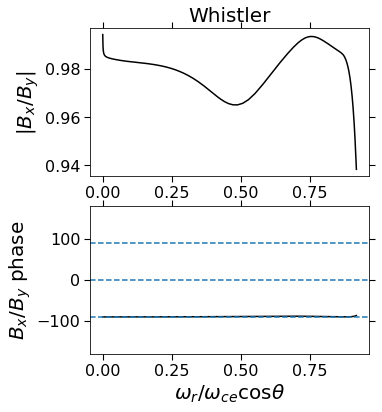

In [100]:
fig, axes = plt.subplots(2, 1, figsize = [5, 6])
ax0, ax1 = axes
ax0.set_title('Whistler')
ax0.plot(whistler_freq_arr.real/1836/np.cos(np.deg2rad(theta)), whistler_eigen_b_xy[0], 'k')
ax0.set_ylabel(r'$|B_{x}/B_{y}|$')
ax1.plot(whistler_freq_arr.real/1836/np.cos(np.deg2rad(theta)), whistler_eigen_b_xy[1], 'k')
ax1.set_xlabel(r'$\omega_r/\omega_{ce} \cos \theta $')
ax1.set_ylabel(r'$B_{x}/B_{y}$ phase')
ax1.axhline(0, linestyle = 'dashed')
ax1.axhline(-90, linestyle = 'dashed')
ax1.axhline(90, linestyle = 'dashed')
ax1.set_ylim([-180, 180])
